In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt

## Model background
Here is an example based on the model of Freyberg, 1988.  The synthetic model is a 2-dimensional MODFLOW model with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 5-year transient stress period.  The calibration period uses the recharge and well flux of Freyberg, 1988; the last stress period use 25% less recharge and 25% more pumping.

The inverse problem has 761 parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yield, calibration and forecast well flux for each of the six wells, and river bed conductance for each 40 cells with river-type boundary conditions.  The inverse problem has 12 head obseravtions, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during both stress periods (observations named ```sw_gw_0``` and ``sw_gw_1``), and the water level in well cell 6 located in at row 28 column 5 at the end of the stress periods (observations named ```or28c05_0``` and ```or28c05_1```).  The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `freyberg/` folder


Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

flopy is installed in /Users/jwhite/Dev/flopy/flopy
   could not parse xul in Freyberg/extra_crispy/freyberg.nam


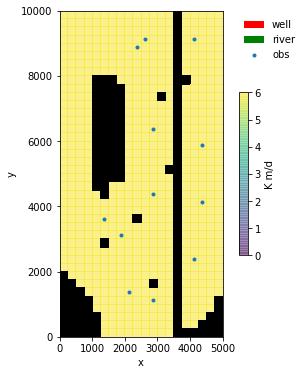

In [2]:
import flopy

# load the model
model_ws = os.path.join("Freyberg","extra_crispy")
ml = flopy.modflow.Modflow.load("freyberg.nam",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,aspect="equal")
ml.upw.hk.plot(axes=[ax],colorbar="K m/d",alpha=0.3)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.dis.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.dis.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="obs")

#plot names on the pumping well locations
wel_data = ml.wel.stress_period_data[0]
wel_x = ml.dis.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = ml.dis.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.add_patch(rect((0,0),0,0,label="well",ec="none",fc="r"))
ax.add_patch(rect((0,0),0,0,label="river",ec="none",fc="g"))

ax.legend(bbox_to_anchor=(1.5,1.0),frameon=False)
plt.savefig("domain.pdf")

The plot shows the Freyberg (1988) model domain.  The colorflood is the hydraulic conductivity ($\frac{m}{d}$).  Red and green cells coorespond to well-type and river-type boundary conditions. Blue dots indicate the locations of water levels used for calibration.

## Using `pyemu`

In [3]:
import pyemu

In [4]:
pst = pyemu.Pst(os.path.join("freyberg","freyberg.pst"))

## Drawing from the prior
Now we need a prior-realized ``ParameterEnsemble``, which stores a ``pandas.DataFrame`` under the hood.

### ```draw```

The ``ParameterEnsemble`` class has several ``draw`` type methods to generate stochastic values from (multivariate) (log) gaussian, uniform and triangular distributions.  Much of what we do is predicated on the gaussian distribution, so let's use that here.

The gaussian draw accepts a `cov` arg which can be a `pyemu.Cov` instance.  If this isn't passed, then the draw method constructs a diagonal covariance matrix from the parameter bounds (assuming a certain number of standard deviations represented by the distance between the bounds - the `sigma_range` argument)

In [6]:
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst,num_reals=200)

``draw`` also accepts a ``num_reals`` argument to specify the number of draws to make:

In [7]:
pe.head()

,rcond03,rch_1,rcond04,hkr26c02,wf5_1,hkr23c04,hkr07c12,hkr02c09,rcond39,rch_2,...,hkr38c11,hkr38c12,hkr38c15,hkr39c05,hkr39c06,hkr39c07,hkr39c09,hkr39c10,hkr39c11,hkr39c13
0,3850.041798,1.059288,24725.280638,16.344212,61.202012,64.619151,4.376049,9.778328,756.188527,0.968386,...,26.776413,0.968301,3.982388,1.829796,10.753646,4.559278,2.081091,3.413169,11.818932,0.973054
1,5679.031772,0.979286,1117.059682,4.167893,66.435826,0.843256,8.703319,3.068128,3155.134138,0.977493,...,4.173789,2.093486,11.865328,1.497314,10.164273,1.344370,2.532985,2.190908,28.948483,7.850384
2,19323.516229,0.990455,5860.438811,2.460566,63.187423,1.274458,19.412088,1.880951,686.306698,0.896304,...,28.012200,4.701120,9.784272,3.671563,19.612848,14.268842,1.648767,8.581436,1.932648,3.664972
3,6979.013249,1.013682,1146.549033,27.599534,63.144562,3.182460,4.699682,17.879271,11319.712591,1.059044,...,6.087620,1.591123,3.570735,1.389313,7.665379,1.254628,24.645767,13.045324,2.569766,2.156735
4,7404.036556,0.981959,17635.358007,1.528375,57.557764,10.829589,9.446352,3.780603,9341.052085,1.084664,...,2.980380,2.641711,4.240446,0.999691,1.766999,5.550393,7.798069,13.724620,15.255797,3.109758


Note that these ``draw`` methods use initial parameter values in the control file (the `Pst.parameter_data.parval`1 attribute) the $\boldsymbol{\mu}$  (mean) prior parameter vector.  To change that, we need to update the parameter values in the control file:

In [10]:
pst.parrep(pst.filename.replace(".pst",".par"))
pst.parameter_data.parval1

parnme
rcond03     4692.095500
rch_1          1.014984
rcond04     4648.801200
hkr26c02       7.260034
wf5_1         55.987200
               ...     
hkr39c07       5.373133
hkr39c09       5.661253
hkr39c10       5.369154
hkr39c11       5.326237
hkr39c13       5.835181
Name: parval1, Length: 761, dtype: float64

In [12]:
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst,num_reals=200)
pe.head()

,rcond03,rch_1,rcond04,hkr26c02,wf5_1,hkr23c04,hkr07c12,hkr02c09,rcond39,rch_2,...,hkr38c11,hkr38c12,hkr38c15,hkr39c05,hkr39c06,hkr39c07,hkr39c09,hkr39c10,hkr39c11,hkr39c13
0,2176.882603,0.969263,2606.793945,7.707606,57.521735,3.781462,15.687377,13.264552,23395.768692,0.987951,...,19.797202,17.389545,1.851688,3.727339,5.815083,0.640541,27.786222,1.118254,1.120286,6.534865
1,11761.178338,0.991983,1598.729164,1.084087,56.059133,39.828964,5.099432,4.777077,12577.798701,0.957714,...,10.963088,1.205452,1.877261,2.096889,12.433065,25.183439,1.193999,2.173352,16.942564,1.246484
2,3508.288652,1.006291,4524.293513,6.540494,53.410986,4.768998,7.061045,9.449237,5689.176229,0.975475,...,6.991687,2.107148,2.723779,11.921327,0.833199,28.060331,14.952887,1.338143,0.402727,3.239473
3,5528.478638,1.011919,11657.638986,2.025969,56.766127,11.506419,0.922159,57.965951,2394.122890,0.956633,...,6.807061,0.522002,1.698684,7.610594,14.709714,7.807010,1.935606,2.826518,0.976253,2.278382
4,7275.051052,1.077489,18081.834295,3.420678,55.865540,3.843995,6.128082,20.382558,1979.985242,1.079430,...,8.160258,5.797018,1.552637,2.219937,2.473403,1.787222,15.454637,11.013539,1.579248,0.488371


## plotting

Since ```ParameterEnsemble``` stores a ```pandas.DataFrame```, it has all the cool methods and attributes we all love.  Let's compare the results of drawing from a uniform vs a gaussian distribution.  The actual dataframe is stored under the private attribute `ParameterEnsemble._df`:

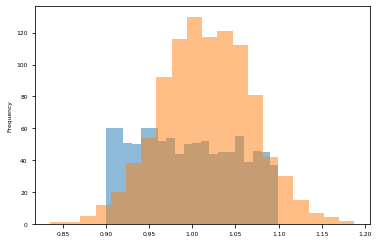

In [13]:
pe = pyemu.ParameterEnsemble.from_uniform_draw(pst=pst,num_reals=1000)
ax = plt.subplot(111)
pe._df.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst,num_reals=1000)
pe._df.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)

The gaussian histo go beyond the parameter bound - bad times.  Luckily, `ParameterEnsemble` includes an `enforce` method to apply parameter bounds:

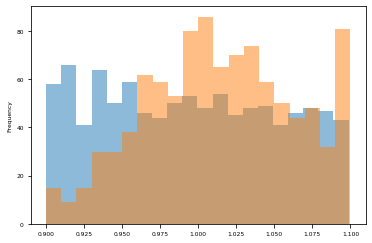

In [18]:
pe = pyemu.ParameterEnsemble.from_uniform_draw(pst=pst,num_reals=1000)
ax = plt.subplot(111)
pe._df.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst,num_reals=1000)
pe.enforce(how="reset")
pe._df.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)

## bayes linear monte carlo

we can use the bayes linear posterior parameter covariance matrix (aka Schur compliment) to "precondition" the realizations using linear algebra so that they hopefully yield a lower phi.  The trick is we just need to pass this
posterior covariance matrix to the draw method.  Note this covariance matrix is the second moment of the posterior (under the FOSM assumptions) and the final parameter values is the first moment (which we `parrep`'ed into the `Pst` earlier)

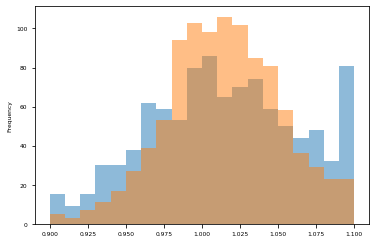

In [19]:
# get the list of forecast names from the pest++ argument in the pest control file
jco = os.path.join("freyberg","freyberg.jcb")
sc = pyemu.Schur(jco=jco)
pe_post = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst,cov=sc.posterior_parameter, num_reals=1000)
pe_post.enforce()
ax = plt.subplot(111)
pe._df.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)
pe_post._df.loc[:,"rch_1"].plot(kind="hist",bins=20,ax=ax,alpha=0.5)


Now we just need to run this preconditioned ensemble to validate the FOSM assumptions (that the realizations do yield an acceptably low phi and that the relation between parameters and forecasts is linear)
